# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
## **Actividad Individual Semana 9: Pronósticos con Series de Tiempo**

#### **Nombre: Angel Irwin Briseño Fierro**
#### **Matrícula: A01796844**


Modelos para predicción de un problema de serie de tiempo:

* **1. Modelo ingenuo**
* **2. Modelo ARIMA**
* **3. Modelo Prophet**
* **4. Modelo LSTM**

# **Preparando los datos**

In [1]:
# Omitamos los Warnings por el momento:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # gráficos de autocorrelación
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/IAAyAA/Semana9/monthly_champagne_sales.csv'
df = pd.read_csv(path, header=0)
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [4]:
df.info()   # Verificación de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [5]:
# Renombrar columnas y transformación de dato object a datetime
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

df.head()

,ds,y
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


### **Agreguemos los ajustes usuales en Series de tiempo:**

In [7]:
# Hagamos una copia del DataFrame df con índices temporales:
df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
df_temp

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [8]:
print(df.shape)
print(df_temp.shape)

(105, 2)
(105, 1)


In [9]:
# Ajuste de la frecuencia de los índices
df_temp.index  # Observamos que aquí todavía no se tiene información del argumento "freq"

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq=None)

In [10]:
# Especifiquemos entonces que nuestros datos están registrados con una frecuencia mensual
df_temp.index.freq = 'MS'  # MS-Month-start-frequency

df_temp.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq='MS')

In [11]:
train = df_temp.iloc[0:-12,:]

test = df_temp.iloc[-12:,:]

In [12]:
train.shape

(93, 1)

In [190]:
test

,ds,y
93,1971-10-01,6981
94,1971-11-01,9851
95,1971-12-01,12670
96,1972-01-01,4348
97,1972-02-01,3564
98,1972-03-01,4577
99,1972-04-01,4788
100,1972-05-01,4618
101,1972-06-01,5312
102,1972-07-01,4298


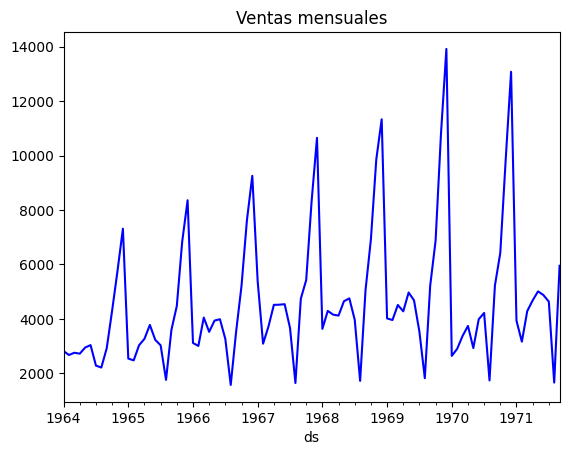

In [13]:
# Gráfico con la periodicidad mensual:
train['y'].plot(title='Ventas mensuales', style='-b')
plt.show()

De este gráfico podemos observar:

1.    Que tenemos una tendencia creciente, con una estacionalidad anual muy marcada

2.   Que el modelo multiplicativo de la serie de tiempo se adaptaría mejor a uno aditivo, ya que la amplitud de la variabilidad se observa que va en aumento.



# **1 - Modelo ingenuo**

In [14]:
test['y'].values

array([ 6981,  9851, 12670,  4348,  3564,  4577,  4788,  4618,  5312,
        4298,  1413,  5877])

In [15]:
history = [x for x in train['y'].values]
predictions = list()

for i in range(len(test['y'])):
  yhat = history[-1]
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i]['y']
  history.append(obs)
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


#### **Este valor de predicción RMSE nos dice que en promedio el error es de aproximadamente más menos 53 pasajeros por cada predicción hecha. Este será nuestro error RMSE a mejorar.**

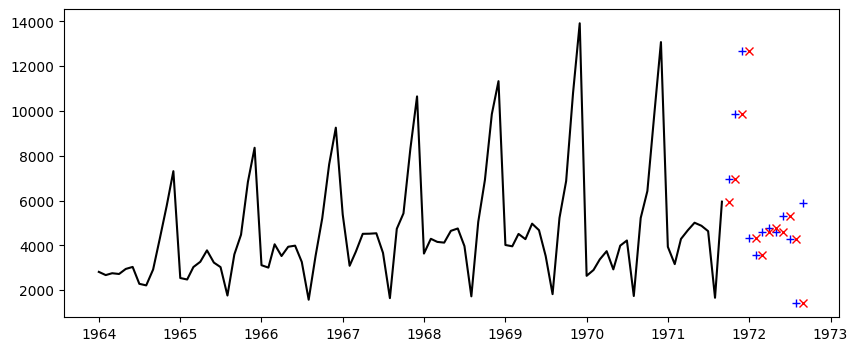

In [16]:
# Gráfica de resultados:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '+b')
ax = plt.plot(test.index, predictions, 'xr')

# **2 - Modelo ARIMA**

### **Análisis preliminar para obtener información de la serie de tiempo y construir el modelo ARIMA(p,d,q).**

*   **AR (AutoRegresivo):** El modelo se basa en la relación entre un valor actual y sus valores pasados.

*   **I (Integrado):** Se refiere a la diferenciación de la serie para hacerla estacionaria, es decir, eliminar tendencias y patrones cíclicos.

*   **MA (Media Móvil):** Usa el error de los valores pasados (las desviaciones entre valores predichos y observados) para corregir el valor actual.

##### **Ahora veamos el gráfico de descomposición de la serie de tiempo en sus componentes de tendencia (trend), estacionalidad (stationality) y residual (residual).**

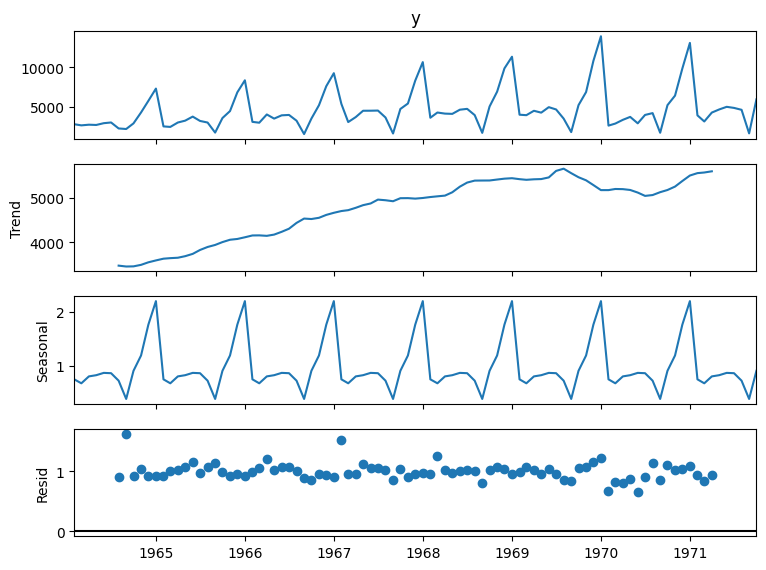

In [17]:
# Gráficos de descomposición estacional:
decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

**Observa del gráfico de Residuos que estos están alrededor del 1, a diferencia del aditivo que usualmente están alrededor del 0.**

##### **Veamos ahora estos dos gráficos que nos hablan si tenemos algún tipo de estacionalidad (i.e., periodicidad). En particular, mensual o trimestral:**

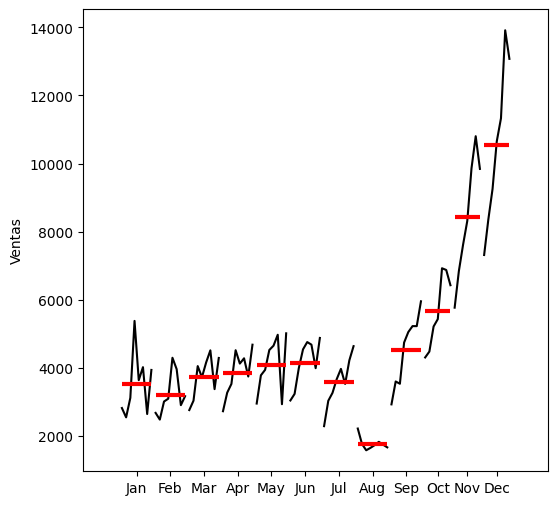

In [18]:
# Estacionalidad mensual:
fig = month_plot(train['y'].resample('M').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
plt.show()

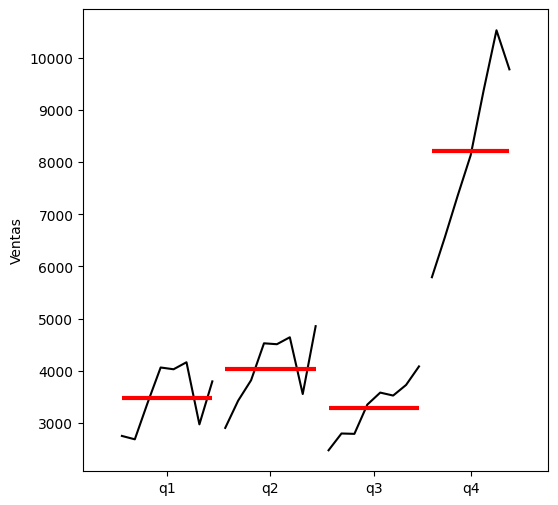

In [19]:
# Estacionalidad trimestral:
fig = quarter_plot(train['y'].resample('Q').mean(), ylabel='Ventas')
fig.set_size_inches(6,6)
plt.show()

### **Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)**

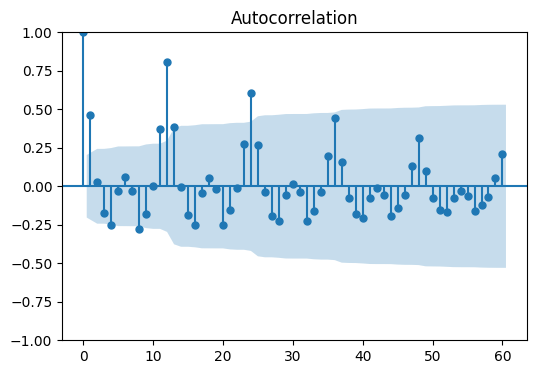

In [20]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['y'], lags=60, ax=ax)
plt.show()

El gráfico inicia con desfase (lag) de 0, lo cual es la correlación de la serie de tiempo consigo misma, la cual es 1.

Posteriormente se muestran las correlaciones de la serie de tiempo original, con la serie desfasada "q" lugares hacia atrás, es decir, de orden "q" en la componente MA de ARIMA(p,d,q).

**El gráfico ACF nos dice en primera instancia que la componente MA de ARIMA(p,d,q) tiene un grado "q" de 13 (en la práctica se puede buscar de 0 a 13).**

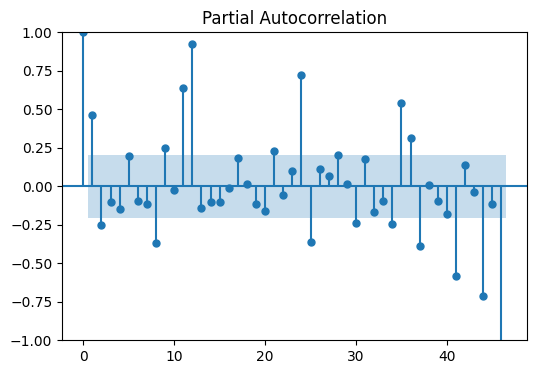

In [21]:
# Gráfico de Autocorrelación Parcial (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['y'], lags = 46, ax = ax, method="ols")
plt.show()

In [22]:
# Remover estacionalidad
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)

# Regresa estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]


In [23]:
history = [x for x in train.loc[:,'y'].values]

predictions = list()

for i in range(len(test['y'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)

  # Generamos el modelo.
  model = ARIMA(diff, order=(3,0,13),) # Si aplicamos diff, entonces d=0 es aplicable.
  model_fit = model.fit(method_kwargs={'maxiter':300})

  yhat = model_fit.forecast()[0]
  yhat = inverse_difference(history, yhat, months_in_year)

  predictions.append(yhat)

  # Observaciones-reales:
  obs = test.iloc[i]['y']
  history.append(obs)

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 6726.531
>Esperado-real = 9851, Predicción = 9898.715
>Esperado-real = 12670, Predicción = 13641.247
>Esperado-real = 4348, Predicción = 4083.349
>Esperado-real = 3564, Predicción = 3728.547
>Esperado-real = 4577, Predicción = 4256.122
>Esperado-real = 4788, Predicción = 5060.375
>Esperado-real = 4618, Predicción = 5300.950
>Esperado-real = 5312, Predicción = 5045.039
>Esperado-real = 4298, Predicción = 4981.132
>Esperado-real = 1413, Predicción = 1692.169
>Esperado-real = 5877, Predicción = 5846.067

Error-Modelo-ARIMA: RMSE: 444.210


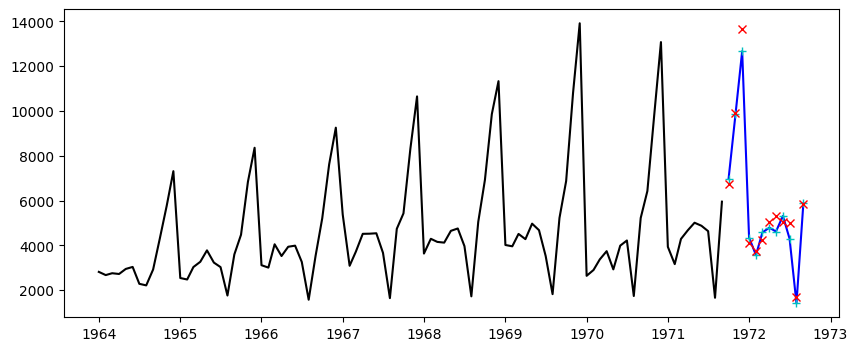

In [24]:
# Veamos su gráfico:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '-b')
ax = plt.plot(test['y'], '+c')
ax = plt.plot(test.index, predictions, 'xr')

# **3 - Modelo Facebook-Meta-Prophet**

In [25]:
train = df.iloc[0:-12,:]
test = df.iloc[-12:,:]

In [26]:
# Modelo Facebbok-Prophet:

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                changepoint_prior_scale=10.,
                seasonality_prior_scale=18)
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0x8bio4d/9lpyqxsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0x8bio4d/od1a0goc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55578', 'data', 'file=/tmp/tmp0x8bio4d/9lpyqxsq.json', 'init=/tmp/tmp0x8bio4d/od1a0goc.json', 'output', 'file=/tmp/tmp0x8bio4d/prophet_model1y9p7gsy/prophet_model-20250613212324.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:23:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
# Calculamos el error RMSE:

pred_FP = model.predict(test)['yhat']
rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet: RMSE: 1322.266


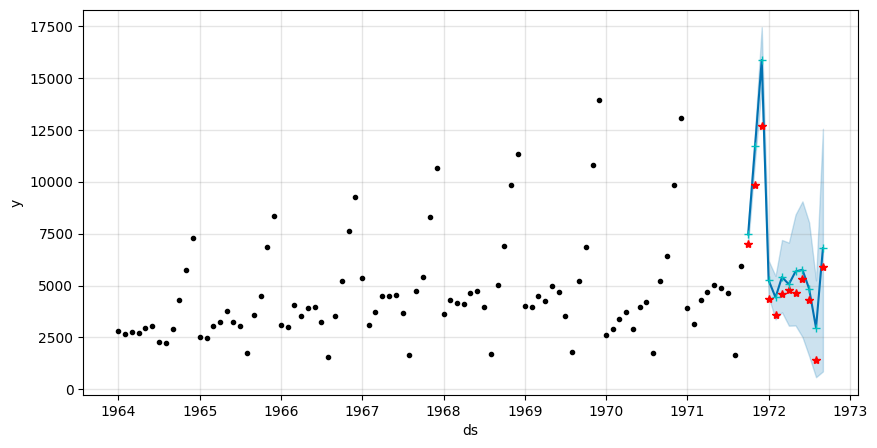

In [28]:
forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)
ax = plt.plot(test['ds'], test['y'], '*r')
ax = plt.plot(test['ds'], forecast['yhat'], '+c')


# **4 - Long Short Term Memory (LSTM)**

In [191]:
def preparando_datos(myData, myDate):
  #Datos Train
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 12

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass

  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # Datos test
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass

  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]

  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


In [198]:
# Split de datos para entrenamiento y prueba
threshold_Date = '1970-10-01'
Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df, threshold_Date)

In [217]:
def myModel():

  model = tf.keras.models.Sequential([tf.keras.layers.LSTM(12, input_shape=(12, 1), activation=tf.nn.relu, recurrent_activation=tf.nn.sigmoid, return_sequences=True),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dense(24, activation=tf.nn.relu),
                                      tf.keras.layers.Dense(1)
                                      ])
  return model


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


my_LSTM_model2 = myModel()

my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0075),
                      loss=tf.keras.losses.mse,    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]
                      )


H = my_LSTM_model2.fit(Train_X,
                       Train_Y,
                       validation_data=(Test_X, Test_Y),
                       epochs=300,
                       batch_size=2,
                       )

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - loss: 32175696.0000 - root_mean_squared_error: 5667.4209 - val_loss: 40584372.0000 - val_root_mean_squared_error: 6370.5864
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 32469696.0000 - root_mean_squared_error: 5693.2363 - val_loss: 40528524.0000 - val_root_mean_squared_error: 6366.2017
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 32371040.0000 - root_mean_squared_error: 5679.1235 - val_loss: 40511856.0000 - val_root_mean_squared_error: 6364.8926
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30600960.0000 - root_mean_squared_error: 5530.3447 - val_loss: 40502596.0000 - val_root_mean_squared_error: 6364.1650
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 31232178.0000 - root_mean_squared_error: 5587.4648 - val_loss: 40497292.0000 - val_root_mean_squared_error: 6363.7480
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 29039288.0000 - root_mean_squared_error: 5387.3418 - val_loss

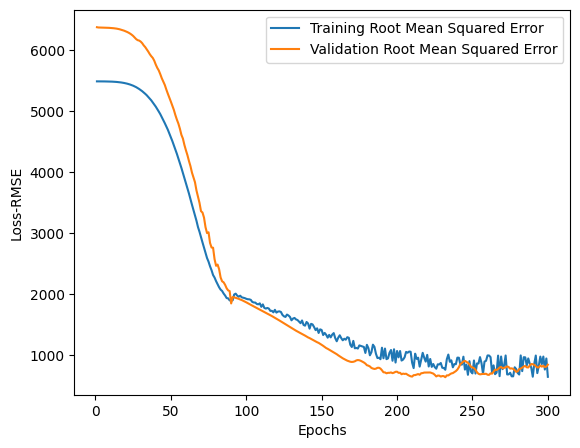

In [218]:
N = 0
epochs = range(N+1, len(H.history["loss"]) + 1)
fig, ax2 = plt.subplots()
fig.set_figheight(5)
ax2.plot(epochs, H.history["root_mean_squared_error"], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
ax2.legend()
plt.show()

In [219]:
# Calculamos el error RMSE:

#pred_LSTM = H.model.predict(Test_X)
pred_LSTM = my_LSTM_model2.predict(Test_X).reshape(-1)

rmse = np.sqrt(mean_squared_error(test['y'].values, pred_LSTM))

print('\nLSTM RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

LSTM RMSE: 836.298


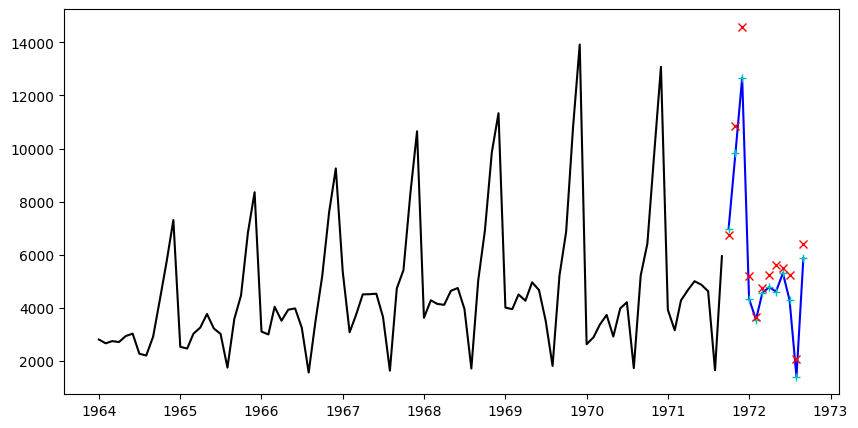

In [220]:
# Graficamos los resultados:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(train['ds'], train['y'], '-k')
ax = plt.plot(test['ds'], test['y'], '-b')
ax = plt.plot(test['ds'], test['y'], '+c')
ax = plt.plot(test['ds'], pred_LSTM, 'xr')

**Conclusión**


## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**